This is a quick list of information spread through the Notebooks and Discussion sections. Hopefully, this is old information to you and your solution already takes all of the following into consideration but if not I hope it can help you improve your model.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
PATH = "../input/stanford-covid-vaccine/"

test = pd.read_json(os.path.join(PATH, 'test.json'), lines=True)
sample_submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))


# 1. Set SN_filter == 1

Most public notebooks I have read already do this but in case you missed it you can find more information in [this discussion topic](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183992). 
Your preprocessing of the training data should incorporate something like this:


In [2]:
train = pd.read_json(os.path.join(PATH, 'train.json'), lines=True)
print(f"Train set length before filtering: {len(train)}")

# https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183992
train = train[train.SN_filter == 1]
print(f"Train set length after filtering: {len(train)}")

Train set length before filtering: 2400
Train set length after filtering: 1589


# 2. Not All Target Variables Are Scored

This should hopefully be also no surprise if you have read the [evaluation section](https://www.kaggle.com/c/stanford-covid-vaccine/overview/evaluation) carefully. 

> While the submission format requires all 5 to be predicted, only the following are scored: reactivity, deg_Mg_pH10, and deg_Mg_50C.

and 

> Positions greater than the seq_scored value of a sample are not scored, but still need a value in the solution file.

That means that you can focus on improving `reactivity`, `deg_Mg_pH10,` and `deg_Mg_50C` for the ranges where `seqpos` < `seq_scored` and ignore the other data points.



In [3]:
submission = pd.DataFrame(columns=[ 'id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'])

for i in range(len(test)):
    df = test.loc[i]

    dummy_values = np.zeros(df.seq_length)
    dummy_values[:df.seq_scored]  = np.full(df.seq_scored, 0.5) # Dummy value

    new_df = pd.DataFrame(data={'id': df.id, 'pos': list(range(df.seq_length)), 
                                'reactivity': dummy_values, # Dummy value
                                'deg_Mg_pH10': dummy_values, # Dummy value
                                'deg_pH10': np.zeros(df.seq_length),# not scored
                                'deg_Mg_50C': dummy_values, # Dummy value
                                'deg_50C': np.zeros(df.seq_length), # not scored
                               })

    new_df['id_seqpos'] = new_df.apply(lambda x: f"{x['id']}_{x['pos']}", axis=1)
    new_df = new_df.drop(['id', 'pos'], axis=1)
    new_df = new_df[[ 'id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']] 
    submission = submission.append(new_df)

submission = submission.reset_index(drop=True)
print(f"Length of sample submission ({len(sample_submission)}) == Length of submission file ({len(submission)})")
submission.to_csv('submission.csv', index = False)
submission.head()

Length of sample submission (457953) == Length of submission file (457953)


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.5,0.5,0.0,0.5,0.0
1,id_00073f8be_1,0.5,0.5,0.0,0.5,0.0
2,id_00073f8be_2,0.5,0.5,0.0,0.5,0.0
3,id_00073f8be_3,0.5,0.5,0.0,0.5,0.0
4,id_00073f8be_4,0.5,0.5,0.0,0.5,0.0


In [4]:
submission[65:70]

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
65,id_00073f8be_65,0.5,0.5,0.0,0.5,0.0
66,id_00073f8be_66,0.5,0.5,0.0,0.5,0.0
67,id_00073f8be_67,0.5,0.5,0.0,0.5,0.0
68,id_00073f8be_68,0.0,0.0,0.0,0.0,0.0
69,id_00073f8be_69,0.0,0.0,0.0,0.0,0.0


# 3. Count-Based Features
I have seen some notebooks using count-based features and wanted to make one note that some of these features are highly correlated because they all indicate the same information about the "pairedness".

* Structure code `.` indicates that a molecule is not paired
* Structure codes `(` and `)` indicate that a molecule is paired
* Predicted Loop Type `S` indicates a stem which is made of pairs.

Since these features contain the same information, I recommend removing redundant features.

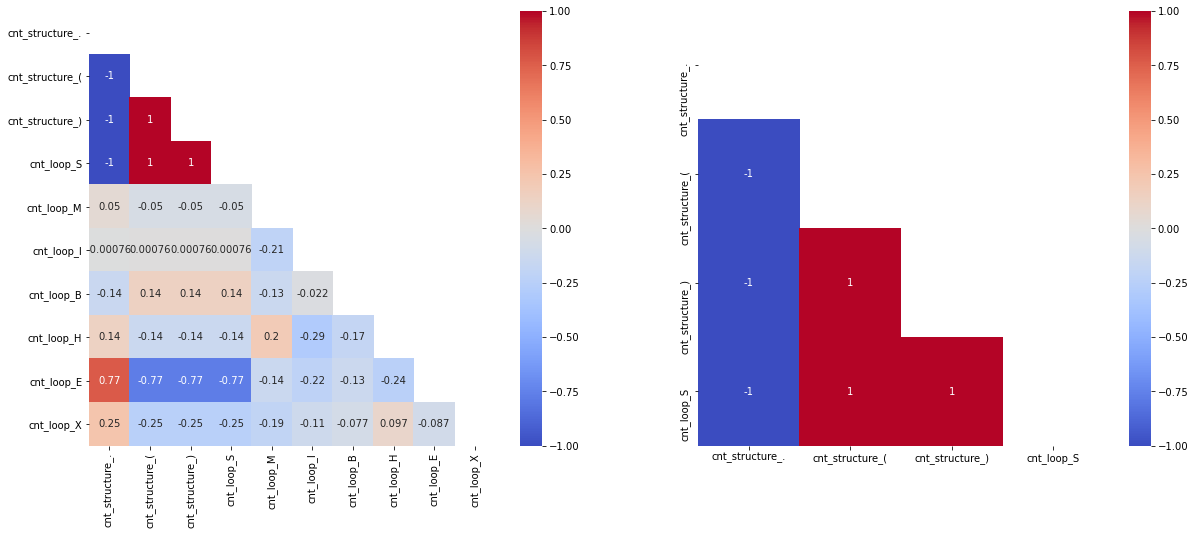

In [5]:
train = train[['id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C']].reset_index(drop=True)

train['train_data'] = 1
test = test[['id', 'sequence', 'structure', 'predicted_loop_type', 'seq_length', 'seq_scored']]
test['train_data'] = 0
all_data = train.append(test).reset_index(drop=True)

for c in ['.','(',')']:
    all_data[f"cnt_structure_{c}"] = all_data.apply(lambda x: ((list(x['structure']).count(str(c)))/(x['seq_length'])), axis = 1)

for c in ['S','M','I','B','H','E','X']:
    all_data[f"cnt_loop_{c}"] = all_data.apply(lambda x: ((list(x['predicted_loop_type']).count(str(c)))/(x['seq_length'])), axis = 1)

    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
correlation_matrix = all_data[['cnt_structure_.', 'cnt_structure_(', 'cnt_structure_)', 'cnt_loop_S', 'cnt_loop_M', 'cnt_loop_I', 'cnt_loop_B', 'cnt_loop_H', 'cnt_loop_E', 'cnt_loop_X']].corr()
matrix = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot = True, cmap='coolwarm', mask=matrix, ax=ax[0])

correlation_matrix = all_data[['cnt_structure_.', 'cnt_structure_(', 'cnt_structure_)', 'cnt_loop_S']].corr()
matrix = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot = True, cmap='coolwarm', mask=matrix, ax=ax[1])

plt.show()

# 4. Sequence Length between Train and Test
This should probably also not come as a surprise to you that the train and test set contain sequences with difference lengths.

Therefore, definitely **check your features for deviations in distributions**.

For example:
* I have seen a few notebooks use the `seqpos` (or position in the sequence/molecule number) as a feature. This could be dangerous.
* [@tito's notebook](https://www.kaggle.com/its7171/dangerous-features) also gives some good remarks.

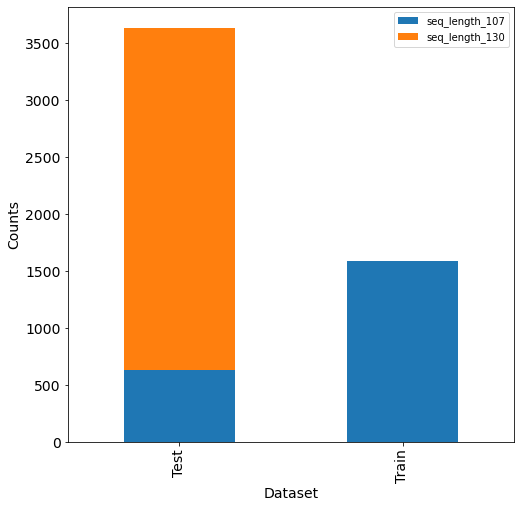

In [6]:
temp = all_data.groupby(['train_data', 'seq_length' ]).id.count().to_frame().reset_index()
temp.columns = ['train_data', 'seq_length', 'counts']
temp.train_data = temp.train_data.replace({0:'Test', 1:'Train'})
temp = temp.pivot(index='train_data',columns='seq_length')
temp.columns = ['seq_length_107', 'seq_length_130']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
temp.plot(kind='bar', stacked=True, ax= ax,  fontsize=14)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()